# Automatically generating object masks with SAM


SamAutomaticMaskGenerator objectlarga mask berishi mumkun. U rasm bo'ylab grid ichidagi single-point input prompts larni tanlab olish orqali ishlaydi, qayski ularni har biridan bir nechta mask larni predict qilishi mumkun. Keyin, masks lar sifati bo'yicha filtrlanadi va non-maximal suppression metodi yordamida deduplicatsiya (yani yaxshimasi olib tashlanadi ) tashlanadi. 
Qo'shimcha imkoniyatlar niqob sifati va miqdorini yanada yaxshilash imkonini beradi, masalan, tasvirni multiple crops da bashorat qilish yoki kichik ajratilgan hududlar va teshiklarni olib tashlash uchun niqoblarni qayta ishlash.

In [4]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

PyTorch version: 2.2.0
Torchvision version: 0.17.0
CUDA is available: True


In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [6]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

### Example image

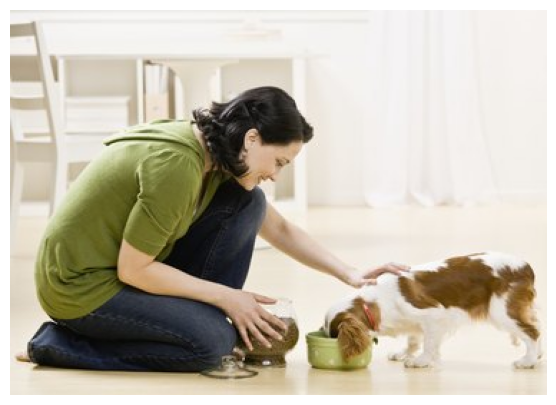

In [24]:
image = cv2.imread('data/puppy.jpg')
image2 = cv2.imread('data/dog.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,5))
plt.imshow(image2)
plt.axis('off')
plt.show()

## Automatic mask generation

In [18]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
sam_checkpoint = "checkpoints/sam_vit_b_01ec64.pth"
model_type = "vit_b"
device = "cuda"

#sam model regist qilamiz
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

#SAM MASK Generatordan class olamiz
mask_generator = SamAutomaticMaskGenerator(sam)

In [25]:
#generate mask 
masks = mask_generator.generate(image2)
print(masks)

[{'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 253, 'bbox': [0.0, 18.0, 18.0, 13.0], 'predicted_iou': 0.9804645776748657, 'point_coords': [[5.859375, 21.015625]], 'stability_score': 0.9921259880065918, 'crop_box': [0, 0, 375, 269]}, {'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 10262, 'bbox': [18.0, 78.0, 131.0, 138.0], 'predicted_iou': 0.9

Mask generator list qaytaradi qaysiki list ichida mask dictionary bor ulardan bir nechta boladi. Va ular quyidagi keylardagi ma'lumotlarni o'z ichiga oladi: 

- segmentation : the mask
- area : the area of the mask in pixels
- bbox : the boundary box of the mask in XYWH format
- predicted_iou : the model's own prediction for the quality of the mask
- point_coords : the sampled input point that generated this mask
- stability_score : an additional measure of mask quality
- crop_box : the crop of the image used to generate this mask in XYWH format

In [26]:
print(len(masks))
print(masks[0].keys())

30
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


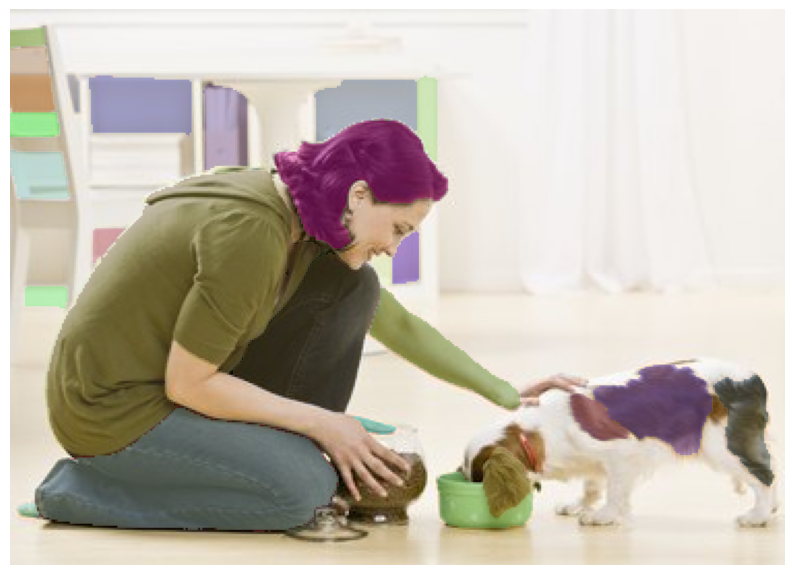

In [34]:
plt.figure(figsize=(10,10))
plt.imshow(image2)
show_anns(masks)
plt.axis('off')
plt.show() 

## Automatic mask generation options

- automatic mask generation da bir nechta sozlanishi mumkin bo'lgan parametrlar mavjud bo'lib, ular qanchalik zich nuqtalar tanlanishini va past sifatli yoki takroriy niqoblarni olib tashlash uchun qanday chegaralar mavjudligini nazorat qiladi.
- Qoshimchasiga, generation avtomatik ravishda crops of image kesilgan segment bo'laklarda ham run bo'ladi, sababi kichik obyektlarda (rasmlarda) ham yaxshi natijani olish uchun va keyingi ishlov berishda adashgan piksellar va holeslarni olib tashlashi mumkin. Mana, ko'proq niqoblarni o'z ichiga oluvchi konfiguratsiyaga misol:

In [38]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam, #our sam model
    points_per_side=32,#The number of points to be sampled along the image
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)


        Arguments:
          model (Sam): The SAM model to use for mask prediction.
          points_per_side (int or None): The number of points to be sampled
            along one side of the image. The total number of points is
            points_per_side**2. If None, 'point_grids' must provide explicit
            point sampling.
          points_per_batch (int): Sets the number of points run simultaneously
            by the model. Higher numbers may be faster but use more GPU memory.
          pred_iou_thresh (float): A filtering threshold in [0,1], using the
            model's predicted mask quality.
          stability_score_thresh (float): A filtering threshold in [0,1], using
            the stability of the mask under changes to the cutoff used to binarize
            the model's mask predictions.
          stability_score_offset (float): The amount to shift the cutoff when
            calculated the stability score.
          box_nms_thresh (float): The box IoU cutoff used by non-maximal
            suppression to filter duplicate masks.
          crop_n_layers (int): If >0, mask prediction will be run again on
            crops of the image. Sets the number of layers to run, where each
            layer has 2**i_layer number of image crops.
          crop_nms_thresh (float): The box IoU cutoff used by non-maximal
            suppression to filter duplicate masks between different crops.
          crop_overlap_ratio (float): Sets the degree to which crops overlap.
            In the first crop layer, crops will overlap by this fraction of
            the image length. Later layers with more crops scale down this overlap.
          crop_n_points_downscale_factor (int): The number of points-per-side
            sampled in layer n is scaled down by crop_n_points_downscale_factor**n.
          point_grids (list(np.ndarray) or None): A list over explicit grids
            of points used for sampling, normalized to [0,1]. The nth grid in the
            list is used in the nth crop layer. Exclusive with points_per_side.
          min_mask_region_area (int): If >0, postprocessing will be applied
            to remove disconnected regions and holes in masks with area smaller
            than min_mask_region_area. Requires opencv.
          output_mode (str): The form masks are returned in. Can be 'binary_mask',
            'uncompressed_rle', or 'coco_rle'. 'coco_rle' requires pycocotools.
            For large resolutions, 'binary_mask' may consume large amounts of
            memory.
        """

In [39]:
masks2 = mask_generator_2.generate(image2)
print(len(masks2))

58


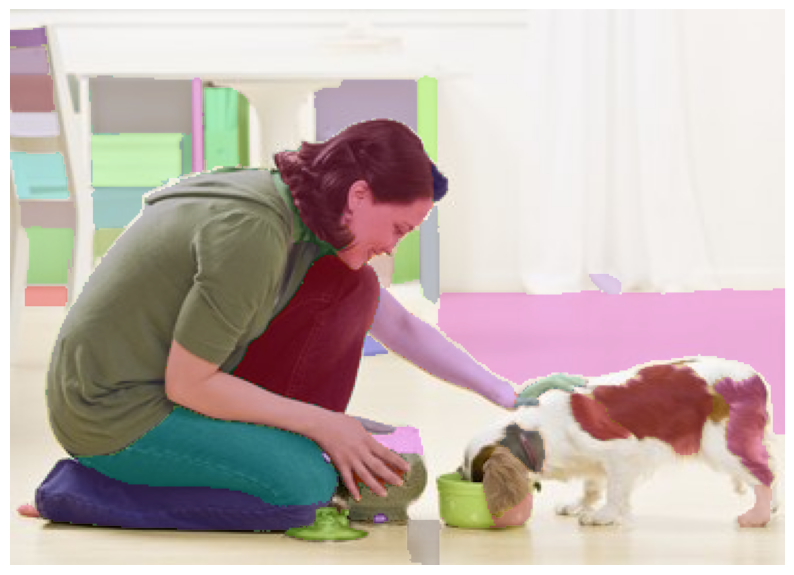

In [40]:
plt.figure(figsize=(10,10))
plt.imshow(image2)
show_anns(masks2)
plt.axis('off')
plt.show() 